--2025-05-02 11:15:08--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.46.172, 16.15.185.146, 54.231.226.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.46.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘/content/val2017.zip’

/content/val2017.zi 100%[===================>] 777.80M  78.6MB/s    in 13s     

2025-05-02 11:15:21 (61.9 MB/s) - ‘/content/val2017.zip’ saved [815585330/815585330]

--2025-05-02 11:15:21--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.113.211, 3.5.8.133, 52.216.216.105, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.113.211|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/annotations.zip’

/co

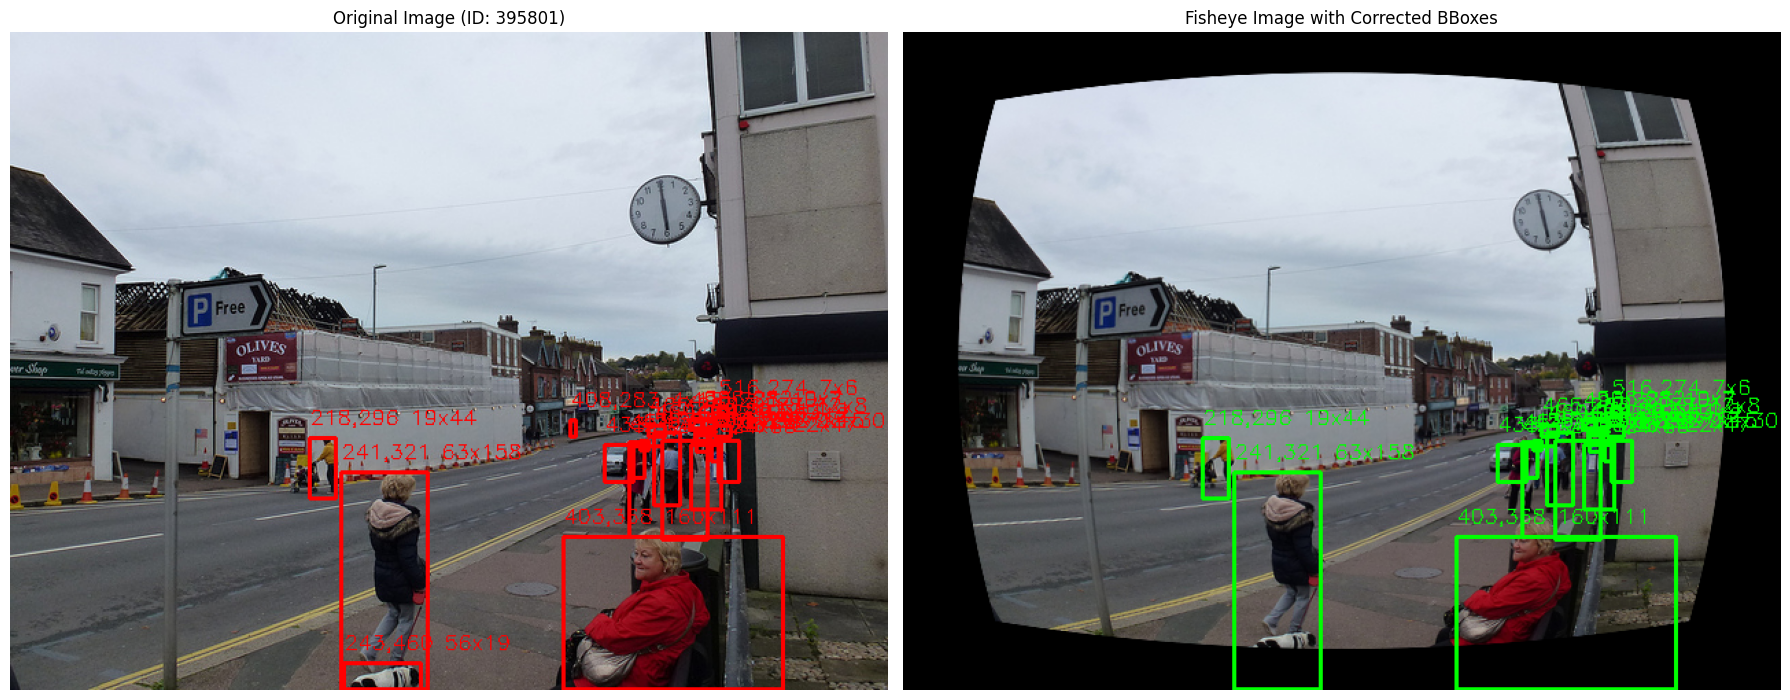


Результаты сохранены в /content/fisheye_coco
Изображение: /content/fisheye_coco/000000395801.jpg
Аннотации: /content/fisheye_coco/fisheye_annotations.json


In [2]:
import cv2
import numpy as np
import os
import json
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from shapely.geometry import Polygon

# Настройки
DATA_DIR = "/content/coco"
IMAGES_DIR = os.path.join(DATA_DIR, "val2017")
ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations/instances_val2017.json")
OUTPUT_DIR = "/content/fisheye_coco"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Скачиваем COCO 2017 (Val)
!wget http://images.cocodataset.org/zips/val2017.zip -O /content/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/annotations.zip
!unzip -q /content/val2017.zip -d /content/coco
!unzip -q /content/annotations.zip -d /content/coco

# Инициализация COCO API
coco = COCO(ANNOTATIONS_FILE)

# Функция для fisheye-аугментации (с меньшими коэффициентами)
def apply_fisheye(image, k1=0.15, k2=0.05):  # Уменьшено для более мягкого эффекта
    h, w = image.shape[:2]
    map_x = np.zeros((h, w), dtype=np.float32)
    map_y = np.zeros((h, w), dtype=np.float32)

    for i in range(h):
        for j in range(w):
            x = (2 * j - w) / w
            y = (2 * i - h) / h
            r = np.sqrt(x**2 + y**2)
            distortion = 1 + k1 * r**2 + k2 * r**4
            map_x[i, j] = (x * distortion + 1) * w / 2
            map_y[i, j] = (y * distortion + 1) * h / 2

    fisheye_img = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    return fisheye_img

# Функция для пересчёта bbox с обрезкой по границам
def apply_fisheye_to_bbox(bbox, img_width, img_height, k1=0.15, k2=0.05):
    x, y, w, h = bbox
    corners = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]

    distorted_corners = []
    for (px, py) in corners:
        nx = (2 * px - img_width) / img_width
        ny = (2 * py - img_height) / img_height
        r = np.sqrt(nx**2 + ny**2)
        distortion = 1 + k1 * r**2 + k2 * r**4
        dx = (nx * distortion + 1) * img_width / 2
        dy = (ny * distortion + 1) * img_height / 2
        distorted_corners.append([dx, dy])

    polygon = Polygon(distorted_corners)
    bounds = polygon.bounds
    new_bbox = [
        max(0, bounds[0]),          # x_min
        max(0, bounds[1]),          # y_min
        min(img_width, bounds[2]) - max(0, bounds[0]),  # width
        min(img_height, bounds[3]) - max(0, bounds[1])  # height
    ]
    return [round(coord, 2) for coord in new_bbox]

# Выбираем случайное изображение
cat_ids = coco.getCatIds(catNms=['person', 'dog', 'car'])
img_ids = coco.getImgIds(catIds=cat_ids)
random_img_id = random.choice(img_ids)
img_info = coco.loadImgs([random_img_id])[0]
img_path = os.path.join(IMAGES_DIR, img_info['file_name'])

# Загружаем данные
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ann_ids = coco.getAnnIds(imgIds=random_img_id, catIds=cat_ids)
annotations = coco.loadAnns(ann_ids)

# Применяем fisheye
fisheye_image = apply_fisheye(image)

# Обрабатываем bbox
print("Сравнение координат bounding boxes (с обрезкой по границам):")
print("{:<30} {:<30}".format("Оригинальные координаты", "Новые координаты"))
print("-"*65)

new_annotations = []
for i, ann in enumerate(annotations):
    original_bbox = [round(coord, 2) for coord in ann['bbox']]
    new_bbox = apply_fisheye_to_bbox(ann['bbox'], img_info['width'], img_info['height'])

    # Пропускаем "битые" bbox
    if new_bbox[2] <= 5 or new_bbox[3] <= 5:  # Ширина/высота < 5px
        print(f"BBox {i+1} пропущен (слишком мал после преобразования)")
        continue

    ann['bbox'] = new_bbox
    new_annotations.append(ann)
    print(f"BBox {i+1}:")
    print(f"  {original_bbox} → {new_bbox}")
    print("-"*65)

# Функция для рисования bbox с подписями
def draw_boxes(img, annotations, color=(0, 255, 0), thickness=2):
    for i, ann in enumerate(annotations):
        bbox = ann['bbox']
        x, y, w, h = map(int, bbox)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, thickness)
        # Подпись с координатами
        label = f"{x},{y} {w}x{h}"
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# Визуализация
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.title(f"Original Image (ID: {random_img_id})")
original_with_boxes = draw_boxes(image.copy(), annotations, color=(255, 0, 0))
plt.imshow(original_with_boxes)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fisheye Image with Corrected BBoxes")
if new_annotations:
    fisheye_with_boxes = draw_boxes(fisheye_image.copy(), new_annotations, color=(0, 255, 0))
else:
    fisheye_with_boxes = fisheye_image.copy()
    plt.text(100, 100, "No valid bboxes after transform", color='red')
plt.imshow(fisheye_with_boxes)
plt.axis('off')

plt.tight_layout()
plt.show()

# Сохраняем результаты
output_image_path = os.path.join(OUTPUT_DIR, img_info['file_name'])
cv2.imwrite(output_image_path, cv2.cvtColor(fisheye_image, cv2.COLOR_RGB2BGR))

output_annotations = {
    "info": coco.dataset['info'],
    "licenses": coco.dataset['licenses'],
    "images": [img_info],
    "annotations": new_annotations,
    "categories": coco.dataset['categories']
}

with open(os.path.join(OUTPUT_DIR, 'fisheye_annotations.json'), 'w') as f:
    json.dump(output_annotations, f)

print(f"\nРезультаты сохранены в {OUTPUT_DIR}")
print(f"Изображение: {output_image_path}")
print(f"Аннотации: {os.path.join(OUTPUT_DIR, 'fisheye_annotations.json')}")Ф

In [3]:
!pip install ultralytics pycocotools matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 805.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [7]:
import cv2
import numpy as np
from shapely.geometry import Polygon

def apply_fisheye(
    image: np.ndarray,
    k1_range: tuple = (0.1, 0.3),  # Случайный коэффициент из диапазона
    k2_range: tuple = (0.01, 0.1),
    center_var: float = 0.1  # Смещение центра искажения (для реализма)
) -> tuple[np.ndarray, dict]:
    """Применяет fisheye-эффект с вариативными параметрами.
    Возвращает искаженное изображение и параметры (k1, k2, center)."""
    h, w = image.shape[:2]

    # Случайные параметры
    k1 = np.random.uniform(*k1_range)
    k2 = np.random.uniform(*k2_range)
    center = (w/2 + np.random.uniform(-center_var, center_var) * w,
              h/2 + np.random.uniform(-center_var, center_var) * h)

    # Векторизованные вычисления (быстрее в 100+ раз)
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    nx = (x - center[0]) / (w / 2)
    ny = (y - center[1]) / (h / 2)
    r = np.sqrt(nx**2 + ny**2)
    distortion = 1 + k1 * r**2 + k2 * r**4

    map_x = (nx * distortion + 1) * (w / 2)
    map_y = (ny * distortion + 1) * (h / 2)

    # Исправление выхода за границы
    map_x = np.clip(map_x, 0, w - 1).astype(np.float32)
    map_y = np.clip(map_y, 0, h - 1).astype(np.float32)

    fisheye_img = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    params = {'k1': k1, 'k2': k2, 'center': center}
    return fisheye_img, params

def apply_fisheye_to_bbox(bbox: list, img_size: tuple, params: dict) -> list:
    """Пересчет BBox с учетом параметров искажения."""
    x, y, w, h = bbox
    img_w, img_h = img_size
    corners = [[x, y], [x + w, y], [x + w, y + h], [x, y + h]]

    distorted_corners = []
    for (px, py) in corners:
        nx = (px - params['center'][0]) / (img_w / 2)
        ny = (py - params['center'][1]) / (img_h / 2)
        r = np.sqrt(nx**2 + ny**2)
        distortion = 1 + params['k1'] * r**2 + params['k2'] * r**4
        dx = nx * distortion * (img_w / 2) + params['center'][0]
        dy = ny * distortion * (img_h / 2) + params['center'][1]
        distorted_corners.append([dx, dy])

    polygon = Polygon(distorted_corners)
    bounds = polygon.bounds
    new_bbox = [
        max(0, bounds[0]),
        max(0, bounds[1]),
        min(img_w, bounds[2]) - max(0, bounds[0]),
        min(img_h, bounds[3]) - max(0, bounds[1])
    ]
    return [round(coord, 2) for coord in new_bbox]

In [8]:
import random
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# Загрузка COCO
coco = COCO(ANNOTATIONS_FILE)
cat_ids = coco.getCatIds(['person', 'car', 'dog'])
img_ids = coco.getImgIds(catIds=cat_ids)
random_img_id = random.choice(img_ids)
img_info = coco.loadImgs([random_img_id])[0]
annotations = coco.loadAnns(coco.getAnnIds(imgIds=random_img_id))

# Загрузка изображения
image = cv2.imread(os.path.join(IMAGES_DIR, img_info['file_name']))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!


In [15]:
fisheye_img, params = apply_fisheye(image)  # Используем улучшенную функцию
print("Параметры искажения:", params)

# Пересчет bbox
new_annotations = []
for ann in annotations:
    new_bbox = apply_fisheye_to_bbox(ann['bbox'], (img_info['width'], img_info['height']), params)
    if new_bbox[2] > 5 and new_bbox[3] > 5:  # Отсеиваем слишком мелкие bbox
        ann['bbox'] = new_bbox
        new_annotations.append(ann)

Параметры искажения: {'k1': 0.10167196539599099, 'k2': 0.08302553685616507, 'center': (226.3790253944984, 304.4441548060523)}


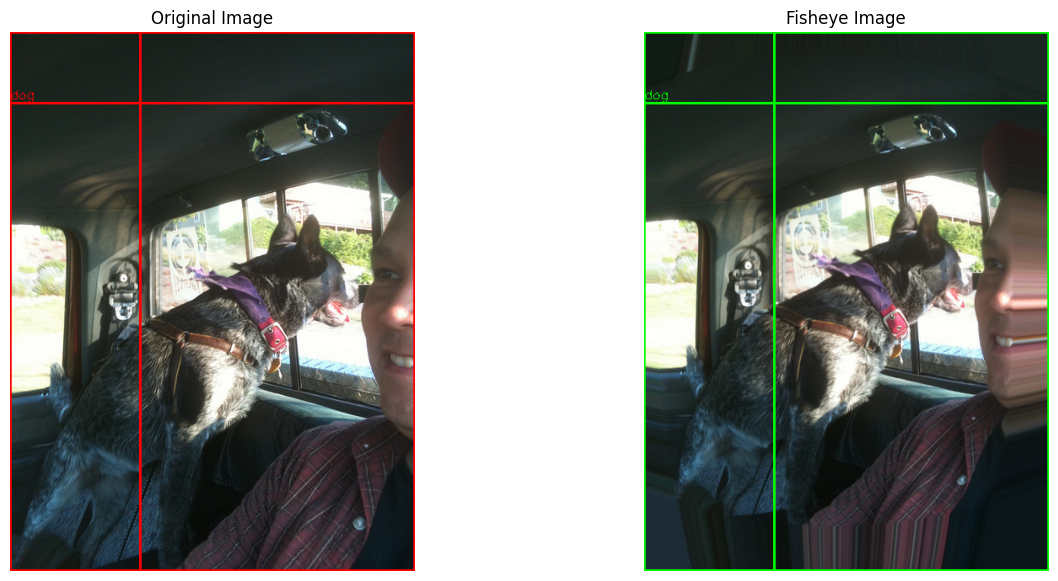

In [16]:
def draw_boxes(img, annotations, color=(0, 255, 0)):
    for ann in annotations:
        x, y, w, h = [int(coord) for coord in ann['bbox']]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{coco.loadCats(ann['category_id'])[0]['name']}",
                    (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(draw_boxes(image.copy(), annotations, (255, 0, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fisheye Image")
plt.imshow(draw_boxes(fisheye_img.copy(), new_annotations, (0, 255, 0)))
plt.axis('off')
plt.show()

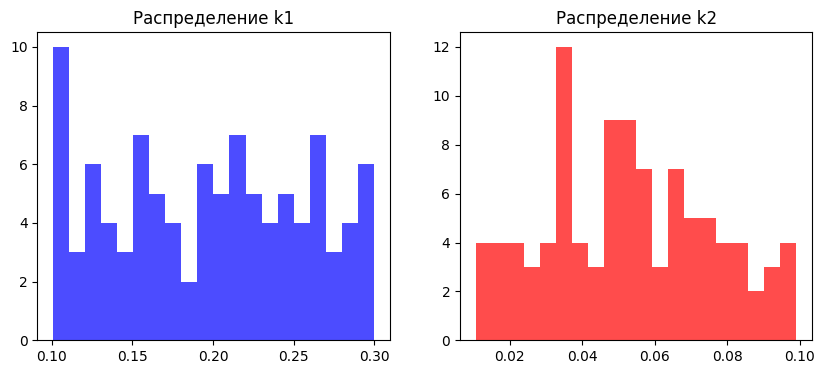

In [17]:
# Генерация 100 случайных искажений и сбор параметров
k1_list, k2_list = [], []
for _ in range(100):
    _, params = apply_fisheye(np.zeros((640, 640, 3)))  # Заглушка
    k1_list.append(params['k1'])
    k2_list.append(params['k2'])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(k1_list, bins=20, color='blue', alpha=0.7)
plt.title("Распределение k1")

plt.subplot(1, 2, 2)
plt.hist(k2_list, bins=20, color='red', alpha=0.7)
plt.title("Распределение k2")
plt.show()

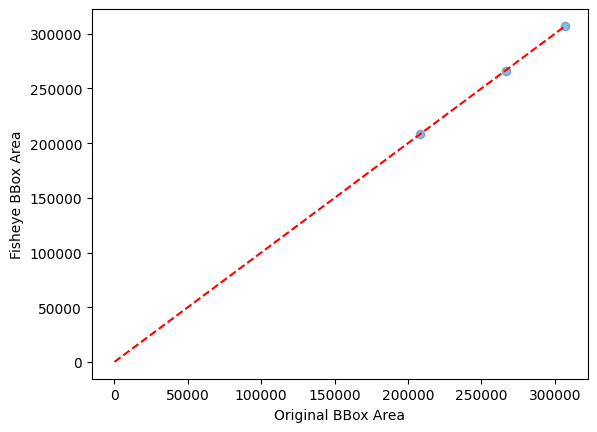

In [18]:
def bbox_area(bbox):
    return bbox[2] * bbox[3]

original_areas = [bbox_area(ann['bbox']) for ann in annotations]
new_areas = [bbox_area(ann['bbox']) for ann in new_annotations]

plt.scatter(original_areas, new_areas, alpha=0.5)
plt.xlabel("Original BBox Area")
plt.ylabel("Fisheye BBox Area")
plt.plot([0, max(original_areas)], [0, max(original_areas)], 'r--')  # Линия y=x
plt.show()

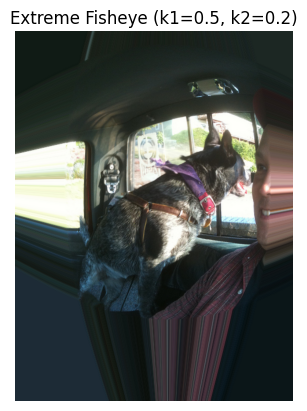

In [19]:
# Максимальное искажение (k1=0.5, k2=0.2)
extreme_img, _ = apply_fisheye(image, k1_range=(0.5, 0.5), k2_range=(0.2, 0.2))
plt.imshow(extreme_img)
plt.title("Extreme Fisheye (k1=0.5, k2=0.2)")
plt.axis('off')
plt.show()

In [20]:
import time

test_image = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
start_time = time.time()
for _ in range(100):
    _ = apply_fisheye(test_image)
print(f"Среднее время: {(time.time() - start_time) / 100:.4f} сек на изображение")

Среднее время: 0.0440 сек на изображение
